In [22]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import gpxSense as gpx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [23]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
	error = y_true - y_pred
	cond  = tf.keras.backend.abs(error) < clip_delta

	squared_loss = 0.5 * tf.keras.backend.square(error)
	linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

	return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
	return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def from_df_to_tfds(df, y, shuffle=True, batch_size=32):
	ds = tf.data.Dataset.from_tensor_slices((df.values, y.values))
	if shuffle:
		ds = ds.shuffle(buffer_size=len(df))
	ds = ds.batch(batch_size)
	return ds

def performance(model, df_train, df_norm_test, y_test):
	evaluations = model.evaluate(from_df_to_tfds(df_norm_test, y_test, shuffle=False, batch_size=1))
	mean_pred = model.predict(from_df_to_tfds(df_norm_test, y_test, shuffle=False, batch_size=1)).mean() * (df_train.max()['hr'] - df_train.min()['hr']) + df_train.min()['hr']
	real_mean = y_test.mean() * (df_train.max()['hr'] - df_train.min()['hr']) + df_train.min()['hr']
	print("Mean prediction:\n", f"{mean_pred:.2f} bpm")
	print("Real mean:\n", f"{real_mean:.2f} bpm")
	print(f"Error in the prediction:\n" f"{abs(mean_pred - real_mean) / real_mean * 100 : .2f}" + f"%")
	print("Metrics:\n", evaluations)
	loss = (evaluations[0] * (df_train['hr'].max() - df_train['hr'].min()))
	mae_loss = (evaluations[1] * (df_train['hr'].max() - df_train['hr'].min()))
	print("Loss:\n", f"{loss:.2f} bpm")
	print("MAE loss:\n", f"{mae_loss:.2f} bpm")
	print(f"Error in the prediction:\n" f"{(evaluations[1]) * 100 : .2f}" + f"%")
	return evaluations

In [30]:
def HyperParamModelSelect(ds_train, ds_val, ds_test, num_features, lr_limits=[0.001, 1e-6], l2_limits=[0.0001, 1e-10]):
	inputs = tf.keras.layers.Input(shape=(num_features,))
	lr = np.linspace(lr_limits[0], lr_limits[1], 10)
	l2 = np.linspace(l2_limits[0], l2_limits[1], 10)
	evals = []
	for i in range(len(lr)):
		tf.keras.backend.clear_session()
		x = tf.keras.layers.Dense(64, activation='leaky_relu',
							kernel_regularizer=tf.keras.regularizers.l2(l2[i])
							)(inputs)
		x = tf.keras.layers.Dense(32, activation='relu',
							kernel_regularizer=tf.keras.regularizers.l2(l2[i])
							)(x)
		x = tf.keras.layers.Dense(16, activation='relu',
							kernel_regularizer=tf.keras.regularizers.l2(l2[i])
							)(x)
		outputs = tf.keras.layers.Dense(1)(x)

		DNNmodel = tf.keras.models.Model(inputs=inputs, outputs=outputs)

		optimizer = tf.keras.optimizers.AdamW(learning_rate=lr[i])

		DNNmodel.compile(optimizer=optimizer, loss=huber_loss_mean, metrics=['mae'])

		callbacks = [
			tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8),
			tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
		]

		history = DNNmodel.fit(ds_train, validation_data=ds_val, epochs=250, callbacks=callbacks, verbose=0)

		print(f"Iteration {i+1} of {len(lr)}")
		evals.append(DNNmodel.evaluate(ds_test))

		if len(evals) > 1:
			if evals[-1][1] < best_eval[1]:
				best_eval = DNNmodel.evaluate(ds_test, verbose=0)
				best_history = history
				DNNmodel.save('best_model.keras')
				with open('best_model_hyperparams.txt', 'w') as f:
					f.write(f"lr: {lr[i]}\nl2: {l2[i]}\n")
		else:
			best_eval = evals[0]
			best_history = history
			DNNmodel.save('best_model.keras')
			with open('best_model_hyperparams.txt', 'w') as f:
				f.write(f"lr: {lr[i]}\nl2: {l2[i]}\n")

	tf.keras.backend.clear_session()
	session = pd.DataFrame(zip(lr, l2), columns=['lr' , 'l2'])
	evals = np.array(evals)
	session['loss'] = evals[:, 0]
	session['mae'] = evals[:, 1]
	return {'session': session, 'best_eval': best_eval, 'best_history': best_history}

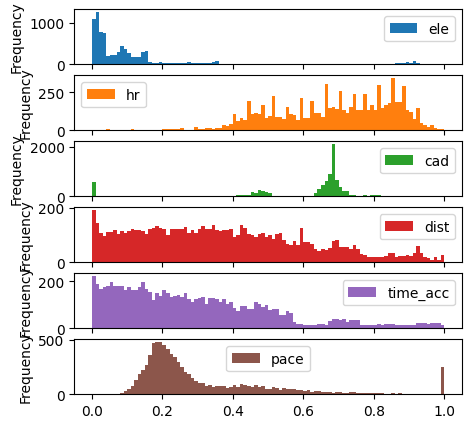

In [31]:
dfs_series = [
	gpx.gpxAnalyseClass("Data/15-01-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/18-01-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/23-01-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/31-01-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/15-02-2024.gpx").df,
	]

df_hill_repeats = [
	gpx.gpxAnalyseClass("Data/27-01-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/04-02-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/13-02-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/19-02-2024.gpx").df
]

dfs_part1 = [
	gpx.gpxAnalyseClass("Data/31-05-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/05-06-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/18-06-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/11-07-2024.gpx").df,
	gpx.gpxAnalyseClass("Data/07-12-2024.gpx").df
]

dfs_part2 = [
	gpx.gpxAnalyseClass("Data/09-01-2025.gpx").df,
	gpx.gpxAnalyseClass("Data/23-01-2025.gpx").df,
	gpx.gpxAnalyseClass("Data/29-01-2025.gpx").df,
	gpx.gpxAnalyseClass("Data/31-01-2025.gpx").df,
	gpx.gpxAnalyseClass("Data/04-02-2025.gpx").df,
	gpx.gpxAnalyseClass("Data/07-02-2025.gpx").df
]

dfs_series = pd.concat(dfs_series, axis=0)
dfs_part1 = pd.concat(dfs_part1, axis=0)

df = pd.concat([dfs_series, dfs_part1], axis=0)
df = df.drop(['lat', 'lon'], axis=1)
df = df.select_dtypes(include=['number'])
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm.plot(subplots=True, figsize=(5, 5), kind='hist', bins=100)
df_norm = df_norm.sample(frac=1)
df_train = df_norm.iloc[:int(df_norm.shape[0] * 0.8)]
df_val = df_norm.iloc[int(df_norm.shape[0] * 0.8):]
y_train = df_train.pop('hr')
y_val = df_val.pop('hr')

In [34]:
gpxTest = gpx.LinearPredictor("Data/08-03-2024_Test1.gpx")
df_test = gpxTest.df
df_norm_test = df_test.drop(['lat', 'lon'], axis=1)
df_norm_test = df_norm_test.select_dtypes(include=['number'])
df_norm_test = (df_norm_test - df.min()) / (df.max() - df.min())
y_test = df_norm_test.pop('hr')

ds_train = from_df_to_tfds(df_train, y_train)
ds_val = from_df_to_tfds(df_val, y_val)
ds_test = from_df_to_tfds(df_norm_test, y_test)

results = HyperParamModelSelect(ds_train, ds_val, ds_test, df_train.shape[1], lr_limits=[7e-4, 3e-4], l2_limits=[1e-5, 4e-5])

Iteration 1 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0042 - mae: 0.0672
Iteration 2 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0058 - mae: 0.0788
Iteration 3 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.0063 - mae: 0.0766
Iteration 4 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.0063 - mae: 0.0821
Iteration 5 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0040 - mae: 0.0636
Iteration 6 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0061 - mae: 0.0766
Iteration 7 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - mae: 0.0801
Iteration 8 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0063 - mae: 0.0777
Iteration 9 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.0075 - mae: 0.0853
Iteration 10 of 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0060 - mae: 0.0754


In [35]:
print("--------Test 1--------")
gpxTest = gpx.LinearPredictor("Data/08-03-2024_Test1.gpx")
df_test = gpxTest.df
df_norm_test = df_test.drop(['lat', 'lon'], axis=1)
df_norm_test = df_norm_test.select_dtypes(include=['number'])
df_norm_test = (df_norm_test - df.min()) / (df.max() - df.min())
y_test = df_norm_test.pop('hr')
DNNmodel = tf.keras.models.load_model('best_model.keras', custom_objects={'huber_loss_mean': huber_loss_mean})
eval = performance(DNNmodel, df, df_norm_test, y_test)

print("--------Test 2--------")
gpxTest = gpx.LinearPredictor("Data/25-04-2024_Test2.gpx")
df_test = gpxTest.df
df_norm_test = df_test.drop(['lat', 'lon'], axis=1)
df_norm_test = df_norm_test.select_dtypes(include=['number'])
df_norm_test = (df_norm_test - df.min()) / (df.max() - df.min())
y_test = df_norm_test.pop('hr')
DNNmodel = tf.keras.models.load_model('best_model.keras', custom_objects={'huber_loss_mean': huber_loss_mean})
eval = performance(DNNmodel, df, df_norm_test, y_test)

print("--------Test 3--------")
gpxTest = gpx.LinearPredictor("Data/25-01-2024_Test3.gpx")
df_test = gpxTest.df
df_norm_test = df_test.drop(['lat', 'lon'], axis=1)
df_norm_test = df_norm_test.select_dtypes(include=['number'])
df_norm_test = (df_norm_test - df.min()) / (df.max() - df.min())
y_test = df_norm_test.pop('hr')
DNNmodel = tf.keras.models.load_model('best_model.keras', custom_objects={'huber_loss_mean': huber_loss_mean})
eval = performance(DNNmodel, df, df_norm_test, y_test)

print("--------Test 4--------")
gpxTest = gpx.LinearPredictor("Data/03-02-2024_Test4.gpx")
df_test = gpxTest.df
df_norm_test = df_test.drop(['lat', 'lon'], axis=1)
df_norm_test = df_norm_test.select_dtypes(include=['number'])
df_norm_test = (df_norm_test - df.min()) / (df.max() - df.min())
y_test = df_norm_test.pop('hr')
DNNmodel = tf.keras.models.load_model('best_model.keras', custom_objects={'huber_loss_mean': huber_loss_mean})
eval = performance(DNNmodel, df, df_norm_test, y_test)

--------Test 1--------
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.0042 - mae: 0.0677
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Mean prediction:
 148.47 bpm
Real mean:
 149.11 bpm
Error in the prediction:
 0.43%
Metrics:
 [0.004149151965975761, 0.06498920172452927]
Loss:
 0.53 bpm
MAE loss:
 8.25 bpm
Error in the prediction:
 6.50%
--------Test 2--------
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.0062 - mae: 0.0806 
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
Mean prediction:
 148.91 bpm
Real mean:
 143.21 bpm
Error in the prediction:
 3.98%
Metrics:
 [0.006634247489273548, 0.08177294582128525]
Loss:
 0.84 bpm
MAE loss:
 10.39 bpm
Error in the prediction:
 8.18%
--------Test 3--------
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - loss: 0.0080 - mae: 0.1021
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step
Mean prediction:
 153.75 bpm
Real mean:
 160.21 bpm
Error in the prediction:
 4.03%
Metrics:
 [0.005193774122744799, 0.0716523602604866]
Loss:
 0.66 bpm
MAE loss:
 9.10

         lr            l2      loss       mae
0  0.001000  1.000000e-04  0.006902  0.080284
1  0.000889  8.888890e-05  0.006554  0.078387
2  0.000778  7.777780e-05  0.006914  0.081088
3  0.000667  6.666670e-05  0.005119  0.068185
4  0.000556  5.555560e-05  0.005509  0.070365
5  0.000445  4.444450e-05  0.007380  0.082039
6  0.000334  3.333340e-05  0.006953  0.082902
7  0.000223  2.222230e-05  0.007266  0.083905
8  0.000112  1.111120e-05  0.006910  0.085886
9  0.000001  1.000000e-10  0.008056  0.107497


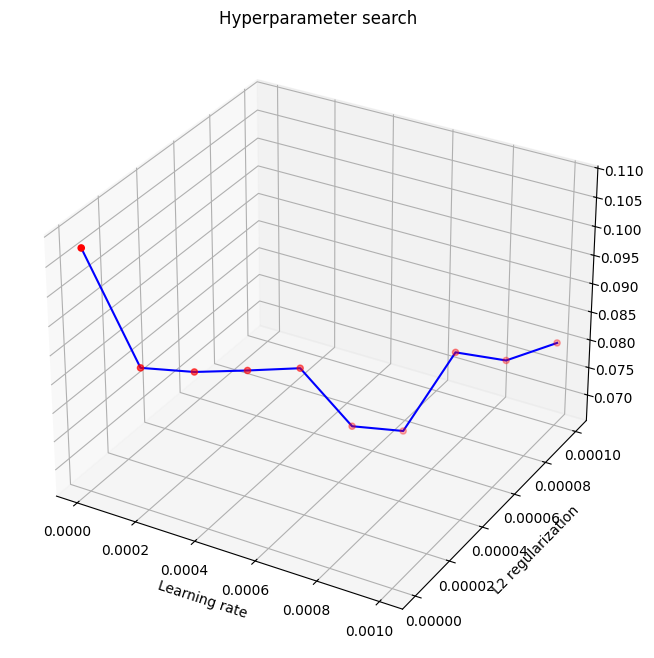

In [28]:
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

print(results['session'])
session = results['session']
x = session['lr']
y = session['l2']
z = session['mae']

ax.plot(x, y, z, color='b')
ax.scatter(x, y, z, color='r')
ax.set_xlabel('Learning rate')
ax.set_ylabel('L2 regularization')
ax.set_title('Hyperparameter search')
plt.show()